In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import os
import matplotlib.pyplot as plt
from configs.RecursiveVPSDE.Markovian_40DLorenz.recursive_Markovian_PostMeanScore_40DLorenz_Stable_T256_H05_tl_110data_StbleTgt import get_config

In [2]:
config = get_config()
num_paths = 1024 if config.feat_thresh == 1. else 10240
assert num_paths == 1024
root_dir = "/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/"

In [3]:
def get_drift_files(config, root_dir ):
    ts_type = f"{config.ndims}DLnz"
    include = (f"_{num_paths}NPaths_{config.t0}t0_{config.deltaT:.3e}dT_").replace(".", "")
    root_nadaraya_dir = root_dir + f"ExperimentResults/Nadaraya/40DLnzLessData/"
    true_files = []
    local_files = []
    for file in os.listdir(root_nadaraya_dir):
        if "IIDNadaraya" in file and ts_type in file and include in file and ((f"{config.forcing_const}FConst").replace(".","") in file):
            if "true" in file:
                true_files.append(root_nadaraya_dir+file)
            elif "global" in file:
                local_files.append(root_nadaraya_dir+file)
    assert len(true_files)>0, "No true files found"
    assert len(local_files)>0, "No local files found"
    assert (len(true_files) == len(local_files))
    def extract_bw_number(s):
        match = s.split("/")[-1].split("_")[3][:-2]
        return float("0." + match)
    true_files = sorted(true_files, key=extract_bw_number)
    local_files = sorted(local_files, key=extract_bw_number)
    bws = [extract_bw_number(f) for f in true_files]
    return true_files, local_files, bws

In [4]:
config = get_config()
true_files, local_files, bws = get_drift_files(config=config, root_dir=root_dir)
len(local_files)

10

/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_40588/3846709293.py:13: RuntimeWarning: invalid value encountered in divide
  total_local_errors = np.sqrt(np.mean(all_global_errors, axis=(0)))/np.sqrt(time_steps)
/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_40588/3846709293.py:14: RuntimeWarning: invalid value encountered in divide
  all_paths_err = np.sqrt(all_global_errors)/np.sqrt(time_steps)


16.11138787009667 0.0073079 inf


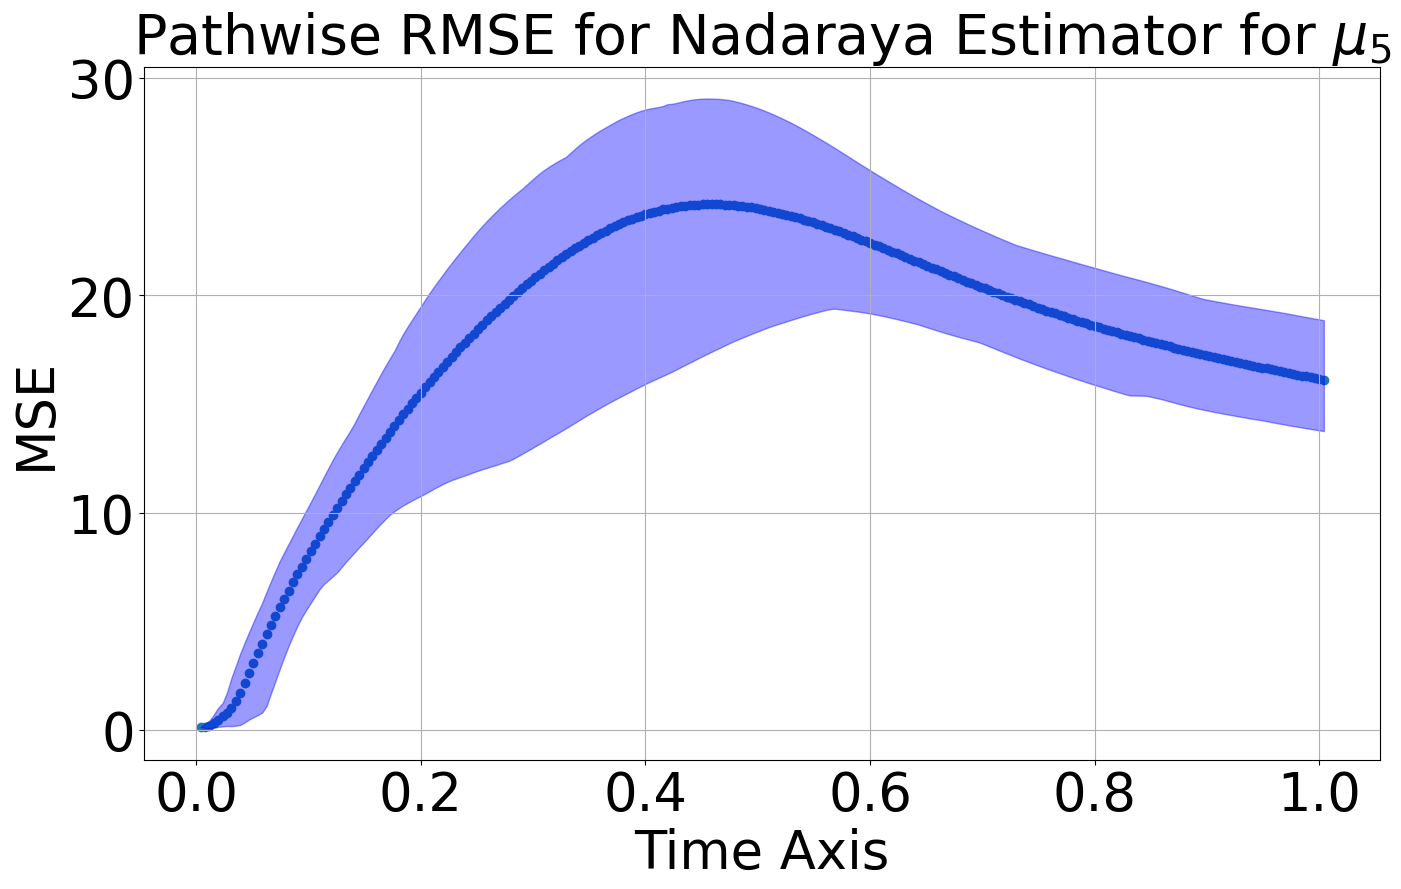

Final time cumulative MSE local-time error 16.11138787009667 with IQR ((13.751521303913302, 18.85264923266538))at bw 0.0073079 for 0.75FConst

15.856269656189653 0.009649 16.11138787009667


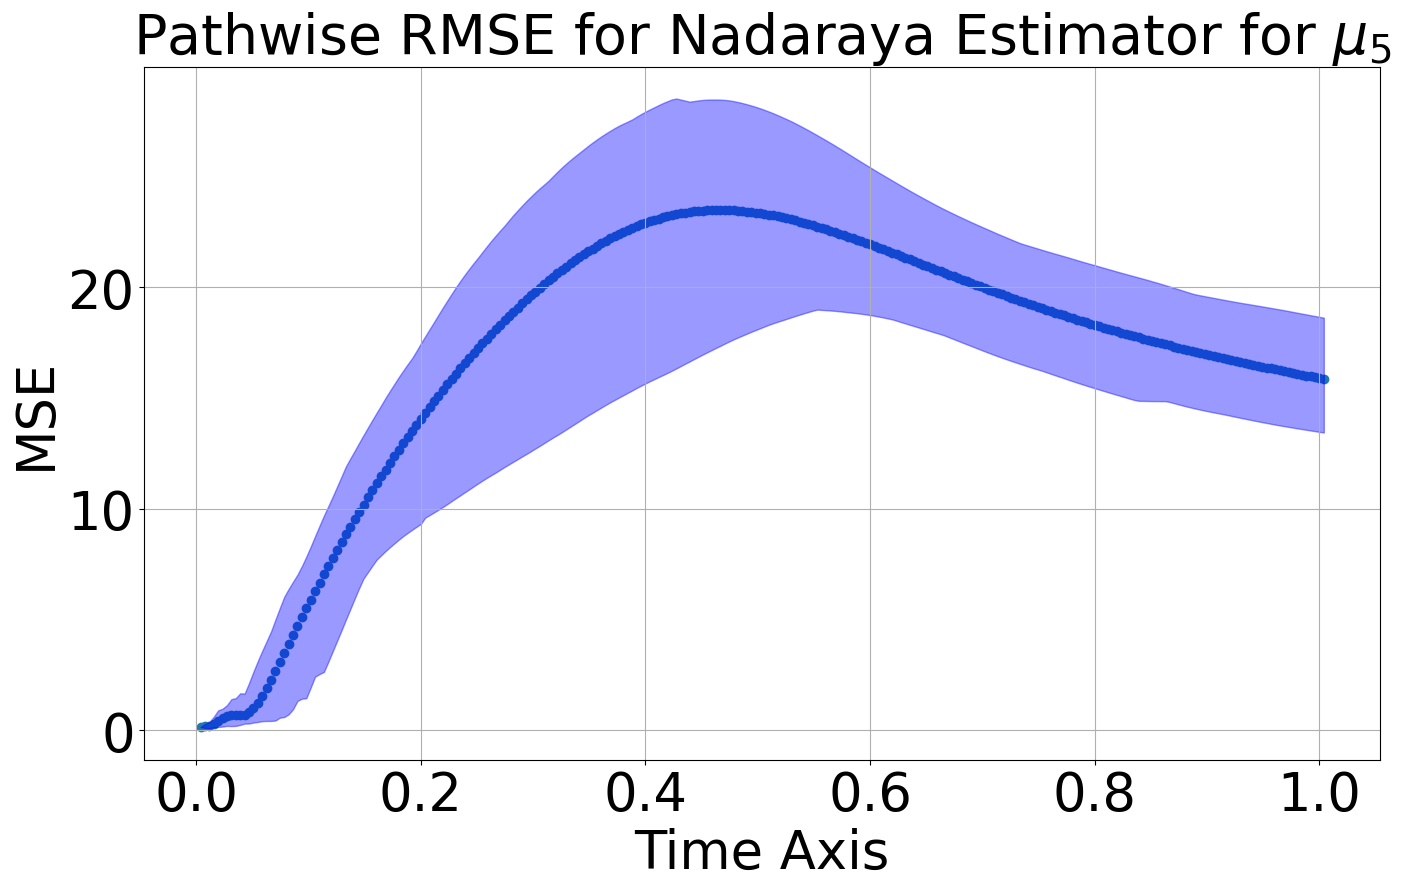

Final time cumulative MSE local-time error 15.856269656189653 with IQR ((13.437674618389226, 18.6253243038388))at bw 0.009649 for 0.75FConst

15.436152737936968 0.0127401 15.856269656189653


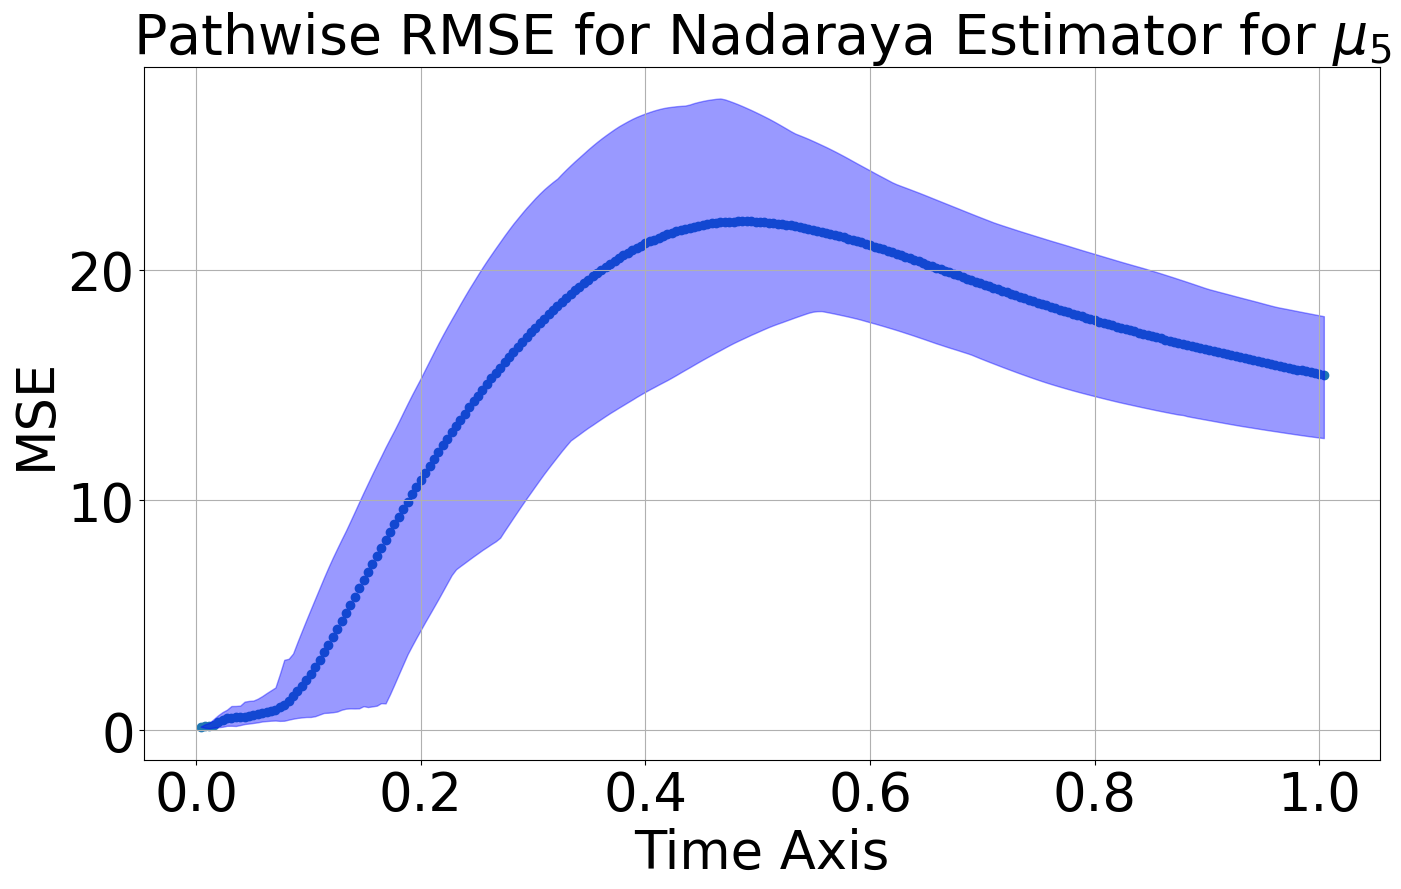

Final time cumulative MSE local-time error 15.436152737936968 with IQR ((12.687959835332423, 17.980934374878448))at bw 0.0127401 for 0.75FConst

14.812393084494541 0.0168214 15.436152737936968


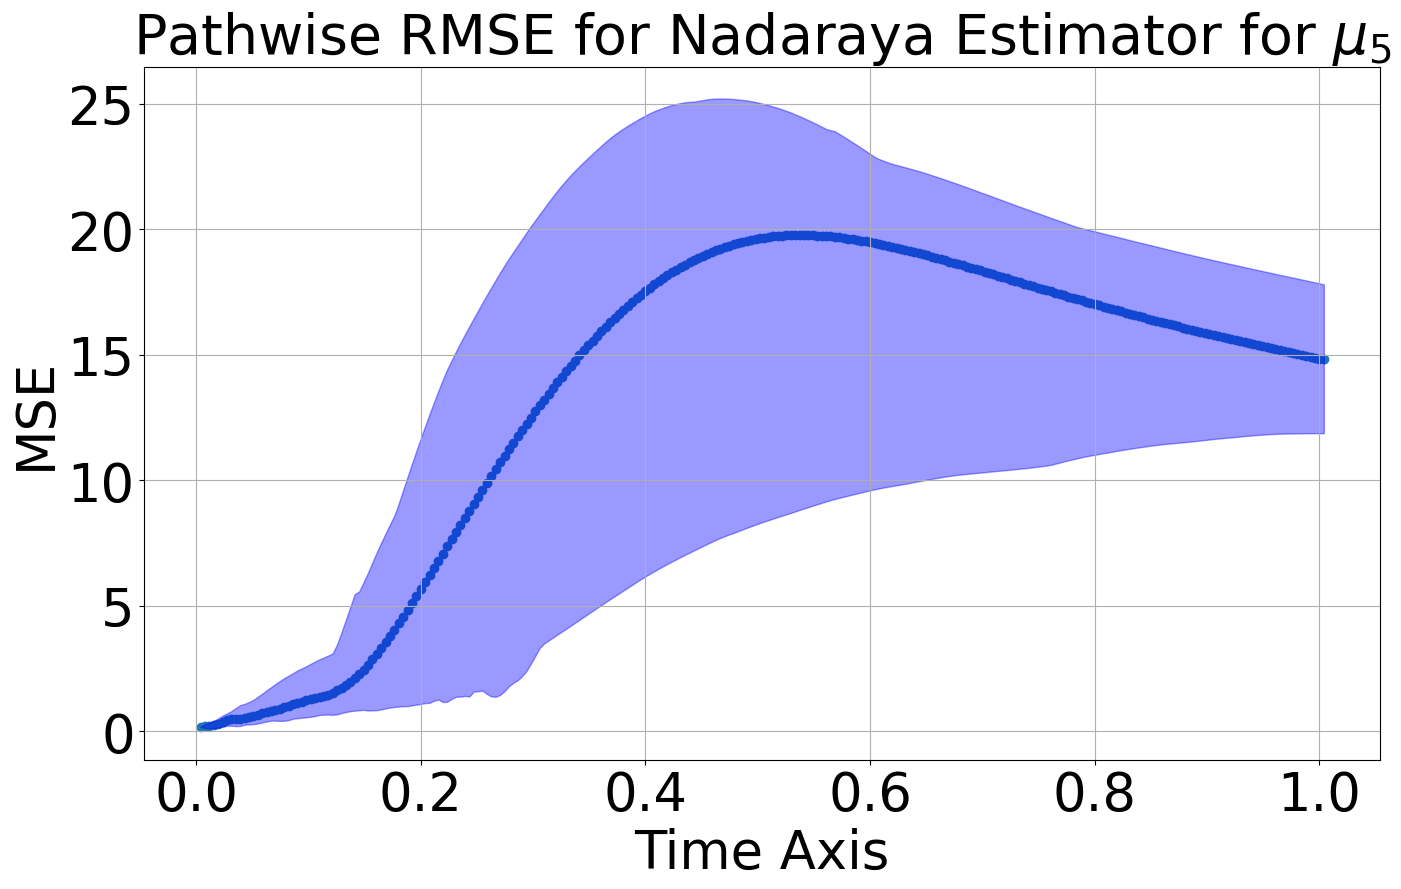

Final time cumulative MSE local-time error 14.812393084494541 with IQR ((11.874112238057322, 17.807236373364464))at bw 0.0168214 for 0.75FConst

13.481906532461462 0.0222102 14.812393084494541


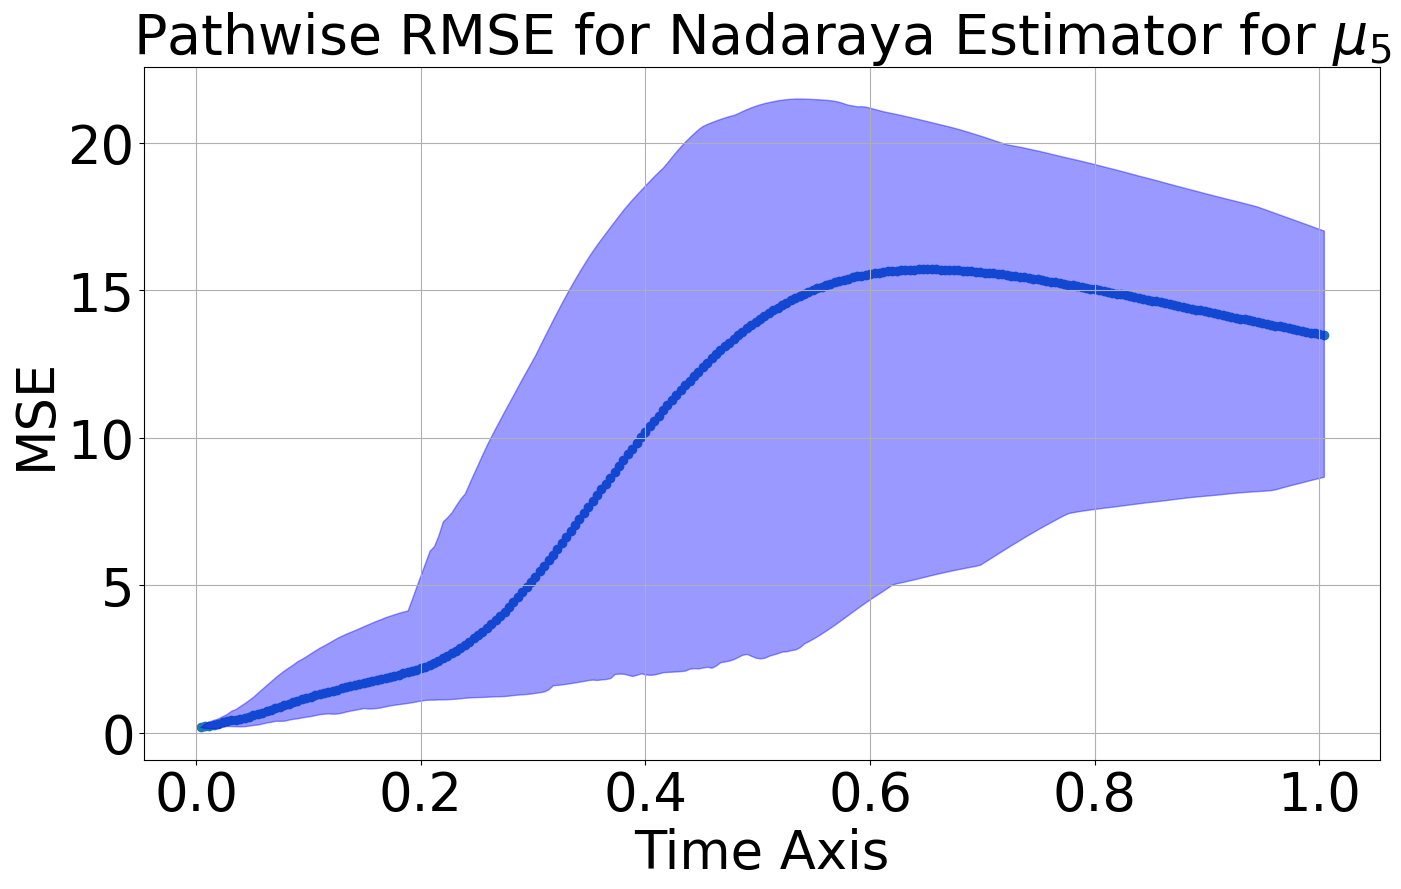

Final time cumulative MSE local-time error 13.481906532461462 with IQR ((8.681563837001494, 17.021835694439986))at bw 0.0222102 for 0.75FConst

10.156568184740557 0.0293252 13.481906532461462


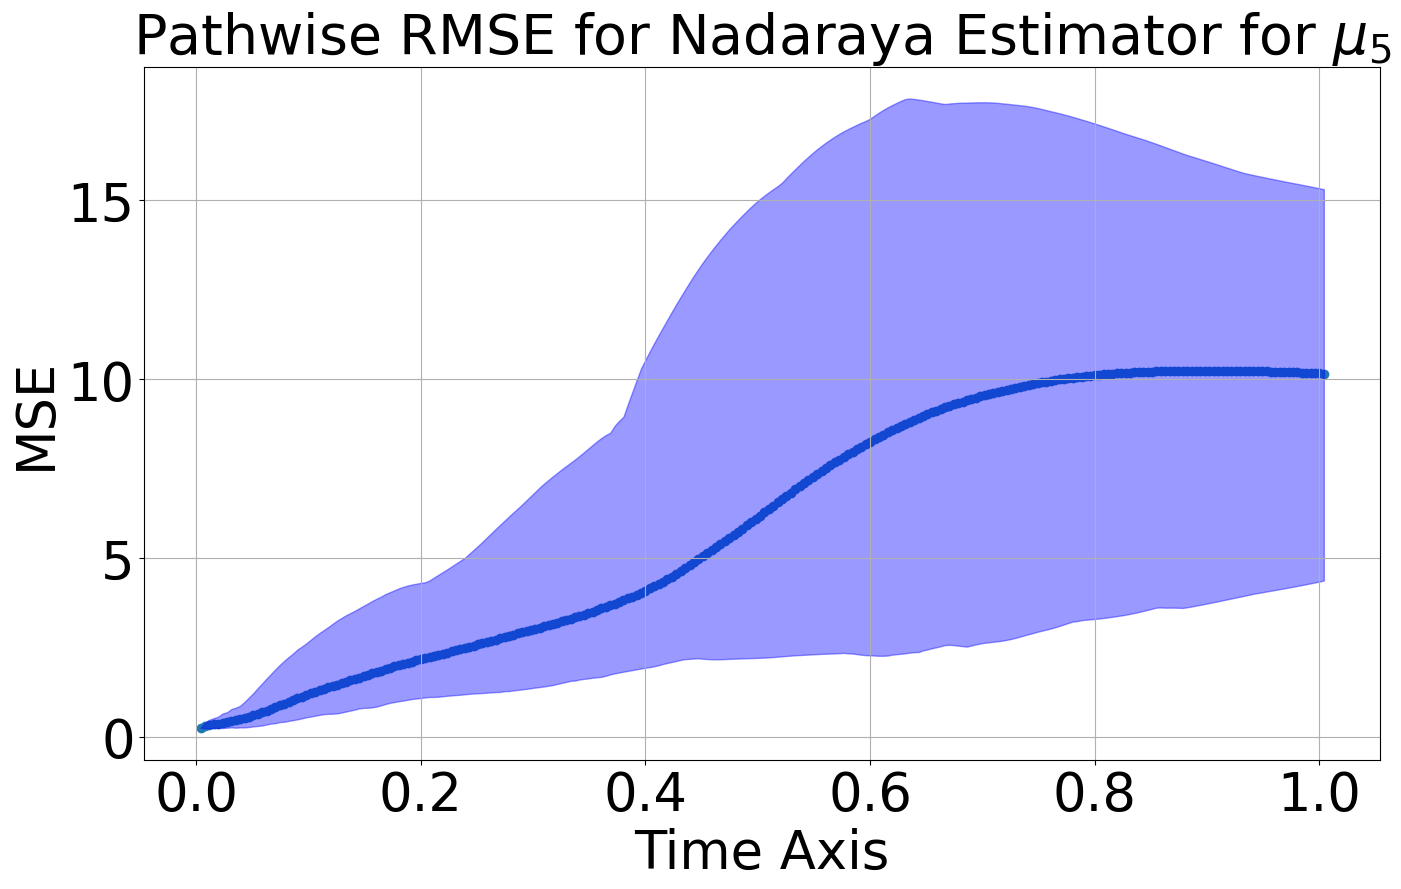

Final time cumulative MSE local-time error 10.156568184740557 with IQR ((4.369930212508352, 15.310276730527011))at bw 0.0293252 for 0.75FConst

6.107302824777737 0.0387196 10.156568184740557


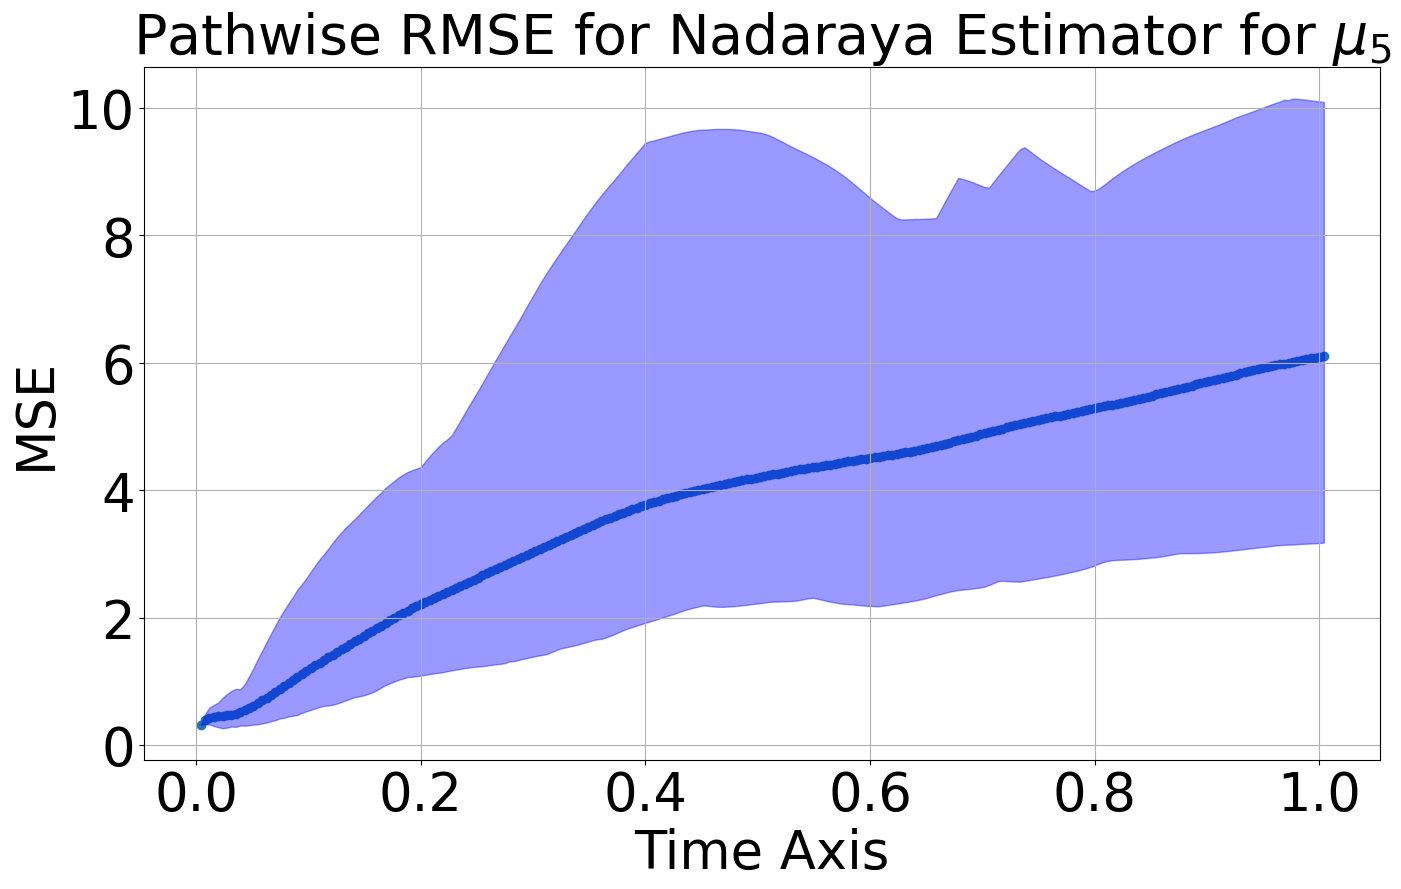

Final time cumulative MSE local-time error 6.107302824777737 with IQR ((3.1761976589177237, 10.091595474144938))at bw 0.0387196 for 0.75FConst

5.3471721690348595 0.0511235 6.107302824777737


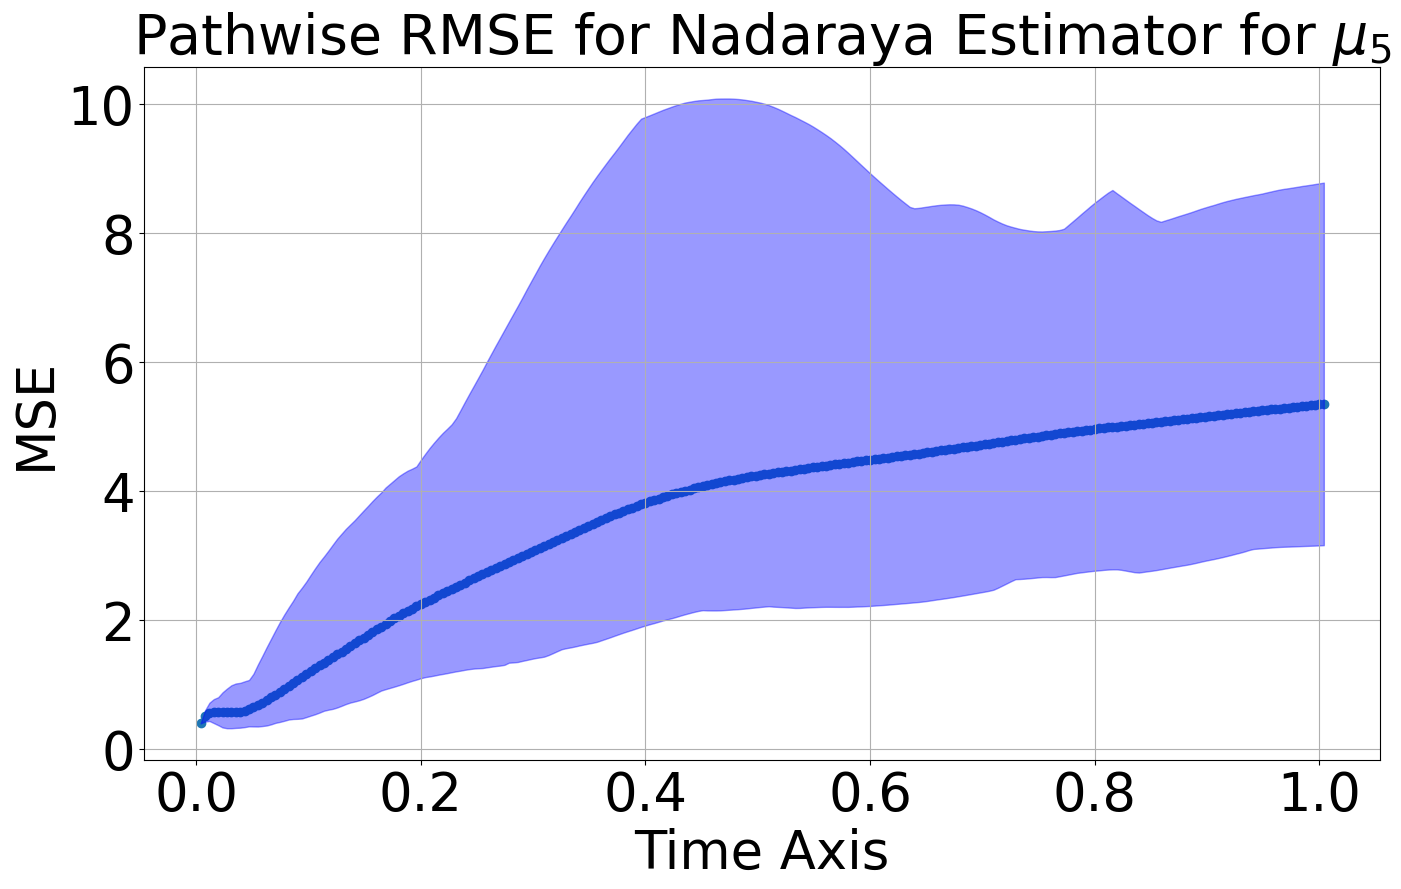

Final time cumulative MSE local-time error 5.3471721690348595 with IQR ((3.1557985557829586, 8.777644688035613))at bw 0.0511235 for 0.75FConst

5.324860319867288 0.067501 5.3471721690348595


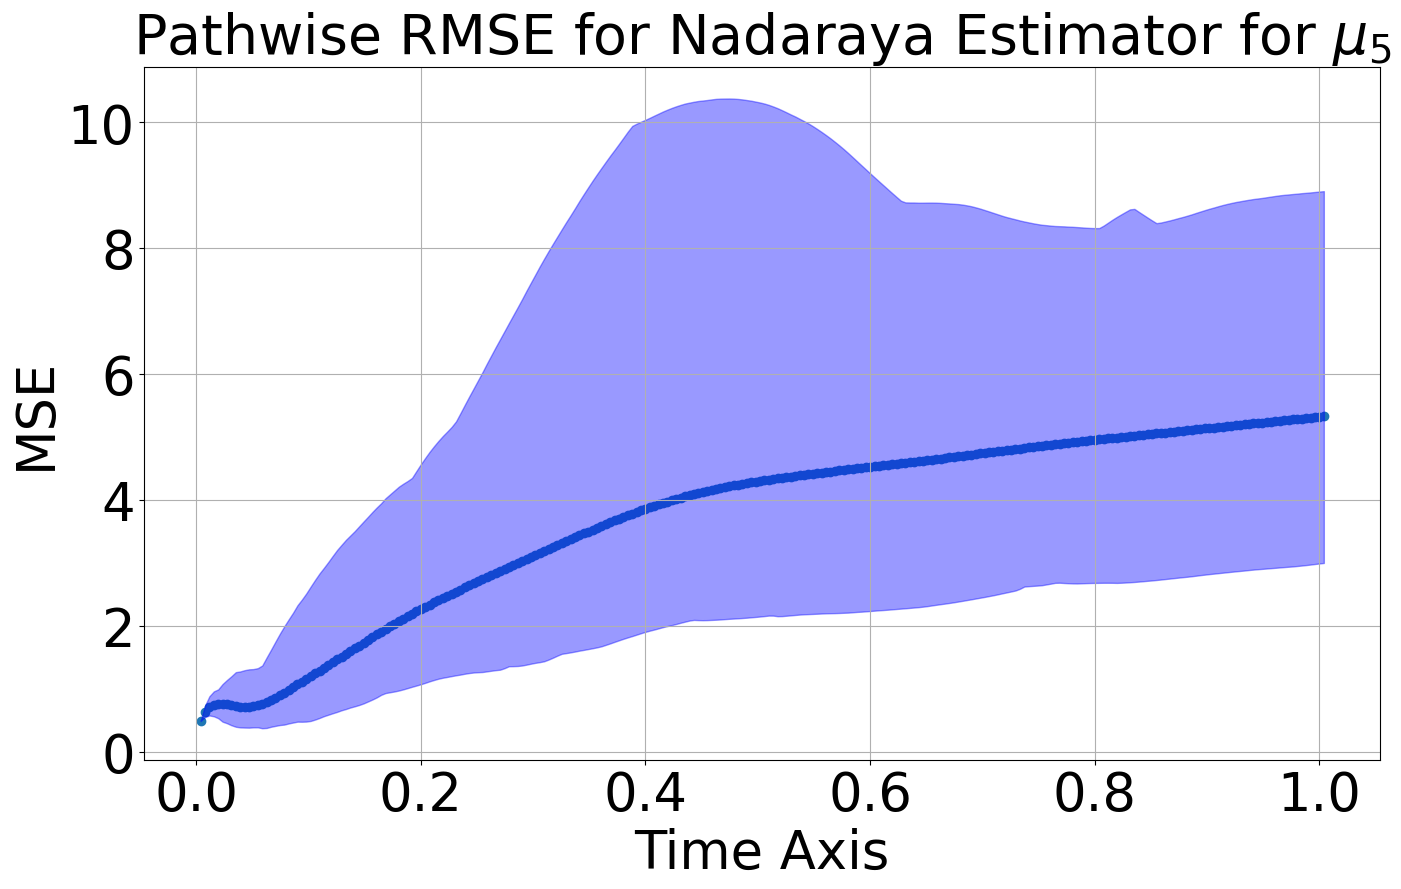

Final time cumulative MSE local-time error 5.324860319867288 with IQR ((2.998821249831773, 8.902526606969412))at bw 0.067501 for 0.75FConst

5.351264272868622 0.0891251 5.324860319867288


In [5]:
curr_rmse = np.inf
toSave = False
i = 0
for file in zip(*[true_files, local_files, bws]):
    bw = file[-1]
    all_true_states = np.load(file[0])
    all_local_states = np.load(file[1])
    if all_local_states.shape[0] != 2: continue
    if (len(all_true_states.shape) == len(all_local_states.shape) == 4):
        time_steps = np.linspace(config.t0,config.deltaT*all_true_states.shape[2],all_true_states.shape[2])
        all_global_errors = np.sum(np.power(all_true_states- all_local_states,2), axis=-1)
        all_global_errors=all_global_errors.reshape(-1, all_global_errors.shape[-1])            # (K, N, T)
        total_local_errors = np.sqrt(np.mean(all_global_errors, axis=(0)))/np.sqrt(time_steps)
        all_paths_err = np.sqrt(all_global_errors)/np.sqrt(time_steps)
        total_local_errors[total_local_errors==np.inf] = 0.
        all_paths_err[all_paths_err==np.inf] = 0.
        total_local_errors_minq, total_local_errors_maxq  = np.quantile(all_paths_err, q=[0.005, 0.995], axis=0) # (T,)
        print(total_local_errors[-1], bw, curr_rmse)
        i += 1
        if total_local_errors[-1]  < curr_rmse:
            curr_rmse = total_local_errors[-1]
            fig, ax = plt.subplots(figsize=(14,9))
            plt.grid(True)
            ax.scatter(time_steps, total_local_errors)
            plt.fill_between(time_steps,y1=total_local_errors_minq, y2=total_local_errors_maxq, color="blue", alpha=0.4)
            ax.set_title(rf"Pathwise RMSE for Nadaraya Estimator for $\mu_5$",fontsize=40)
            ax.set_ylabel("MSE", fontsize=38)
            ax.set_xlabel("Time Axis", fontsize=38)
            ax.tick_params(labelsize=38)
            plt.tight_layout()
            if toSave:
                plt.savefig((root_dir + f"DiffusionModelPresentationImages/IIDNadaraya/40DLnzLessData/IIDNadaraya_{config.ndims}DLnz_DriftTrack_{round(bw, 6)}bw_{config.forcing_const}FConst_{config.forcing_const}FConst_{round(total_local_errors_minq[-1], 8)}_MinIQR_{round(total_local_errors[-1], 8)}MeanIQR_{round(total_local_errors_maxq[-1], 8)}_MaxIQR").replace(".", "")+".png")
            plt.show()
            plt.close()
            print(f"Final time cumulative MSE local-time error {total_local_errors[-1]} with IQR ({total_local_errors_minq[-1], total_local_errors_maxq[-1]})at bw {bw} for {config.forcing_const}FConst\n")

In [6]:
from utils.resource_logger import wallclock_and_system_metrics
data = wallclock_and_system_metrics(config.nadaraya_resource_logging_path, inclusive=False)
data

{'progress_name': 'idx',
 'span_units': 10.0,
 'wall_clock_h_total': 11.93512679292096,
 'wall_clock_per_unit_h': 1.193512679292096,
 'cpu_avg_pct': 1.5977715877437424,
 'cpu_peak_pct': 6.7,
 'ram_avg_gib': 135.92176545960987,
 'ram_peak_gib': 151.812404,
 'gpu_util_avg_pct': None,
 'gpu_util_peak_pct': None,
 'gpu_mem_avg_gib': None,
 'gpu_mem_peak_gib': None}